# **Import Libraries**

In [9]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm
sns.set_theme(style="darkgrid")

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [11]:
IMG_SIZE = 224
batch_size = 32

train_path = "butterfly dataset/train"
test_path = "butterfly dataset/test"
train_csv = "butterfly dataset/Training_set.csv"
test_csv = "butterfly dataset/Testing_set.csv"

# **Data Exploration**

In [12]:
data_df = pd.read_csv(train_csv)
data_df.shape

(6499, 2)

In [13]:
data_df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [14]:
label_counts = data_df['label'].value_counts().to_dict()
label_dict = {label: idx for idx, label in enumerate(label_counts.keys())}
label_dict_rev = {new_label: orig_label for orig_label, new_label in label_dict.items()}

C:\Users\Thanos\AppData\Local\Temp\ipykernel_19772\1846301095.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Count', y = 'Label', data=df, palette='viridis')


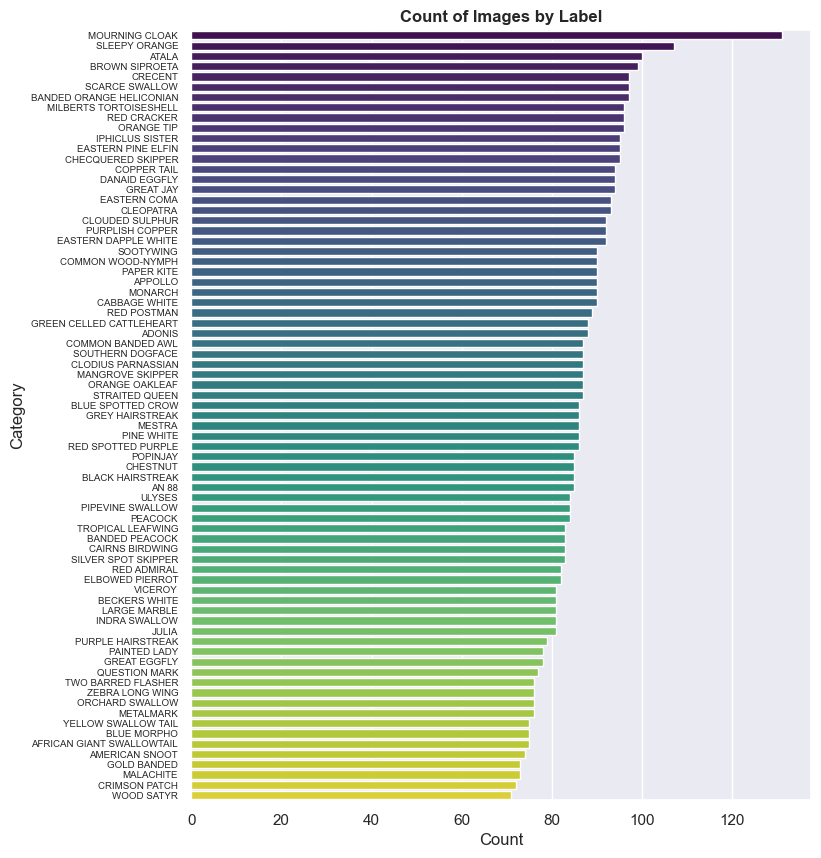

In [15]:
plt.figure(figsize=(8, 10))
df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])
sns.barplot(x = 'Count', y = 'Label', data=df, palette='viridis')
plt.title('Count of Images by Label', fontweight='bold')
plt.yticks(fontsize=7)
plt.ylabel("Category");

### **Utility functions to show images** 

In [16]:
def get_image(path):
    img_bgr = cv2.imread(path)
    img_rgb = img_bgr[:,:,::-1]
    return img_rgb

def show_random_butterflies(df,fold_path, n_img=9):
    sample_df = df.sample(n_img)
    img_names = list(sample_df['filename'])
    label_names = list(sample_df['label'])
    
    size = np.sqrt(n_img)
    if int(size)*int(size) < n_img:
        size = int(size) + 1
    size = int(size) 
    
    plt.figure(figsize=(6,6))
    for ind, (img_name, label) in enumerate(zip(img_names, label_names)):
        img_path = fold_path + "/" + img_name
        img = get_image(img_path)
        
        plt.subplot(size, size, ind+1)
        plt.imshow(img)
        plt.title(label, fontsize=8)
        plt.axis('off')
    plt.show()

def show_same_label_butterflies(label, df,fold_path, n_img=9):
    
    sample_df = df[df['label'] == label].sample(n_img)
    img_names = list(sample_df['filename'])
    
    size = np.sqrt(n_img)
    if int(size)*int(size) < n_img:
        size = int(size) + 1
    size = int(size) 
    
    plt.figure(figsize=(6,6))
    
    for ind, img_name in enumerate(img_names):
        img_path = fold_path + "/" + img_name
        img = get_image(img_path)
        
        plt.subplot(size, size, ind+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(label, fontsize=12, fontweight='bold')
    plt.show()

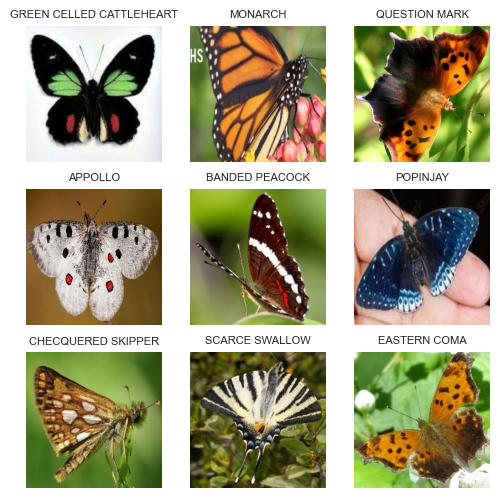

In [17]:
show_random_butterflies(data_df, train_path)

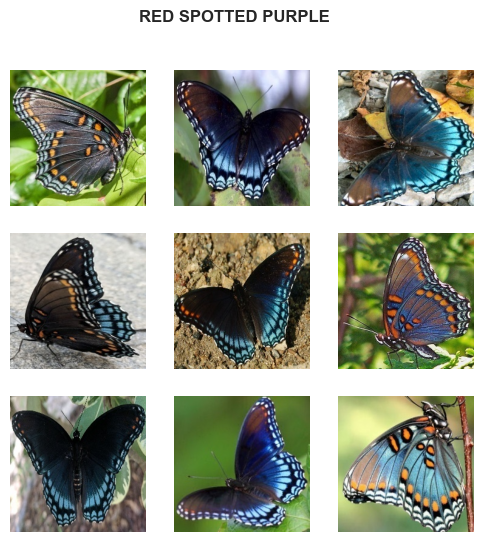

In [18]:
show_same_label_butterflies("RED SPOTTED PURPLE", data_df, train_path)

# **DataLoaders Creation**

In [19]:
class ButterflyDataset(Dataset):
    def __init__(self, df, fold_path, train = True, transforms = None):
        self.df = df
        self.fold_path = fold_path
        self.train = train
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = self.fold_path + "/" + row['filename']
        img = (get_image(img_path)/255.0).astype(np.float32)
        
        if self.transforms:
            img  = self.transforms(image = img)['image']
        
        if self.train:
            return img, label_dict[row['label']]
        
        return img, 0         

In [20]:
train_transforms = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomResizedCrop(IMG_SIZE, IMG_SIZE),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    ToTensorV2(),
])

val_transforms = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    ToTensorV2()
])

NameError: name 'A' is not defined

In [ ]:
train_df, val_df = train_test_split(data_df, test_size=0.2, stratify=data_df['label'])

train_df = train_df.reset_index()
val_df = val_df.reset_index()

train_ds = ButterflyDataset(train_df, train_path, transforms = train_transforms)
val_ds = ButterflyDataset(val_df, train_path, transforms=val_transforms)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

In [ ]:
show_batch(train_dl)

### **Utility functions to move Data into GPUs if available**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# **Model**

In [ ]:
class ViTModel(nn.Module):
    def __init__(self):
        super(ViTModel, self).__init__()
        self.network = torchvision.models.vit_b_16()
        num_ftrs = self.network.heads.head.in_features
        self.network.heads.head = nn.Linear(num_ftrs, len(label_dict))
        
    def forward(self, x):
        logits = self.network(x)
        return logits
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.heads.head.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad = True

# **Training**

In [ ]:
def fit(epochs, lr, model, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        train_losses = []
        train_accs = []
        for batch in tqdm(train_dl):
            inputs, targets = batch
            preds = model(inputs)

            loss = loss_fn(preds, targets)
            acc = (preds.argmax(dim=1) == targets).float().mean()
            
            train_losses.append(loss)
            train_accs.append(acc)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        val_losses = []
        val_accs = []
        for batch in val_dl:
            inputs, targets = batch
            preds = model(inputs)
            
            loss = loss_fn(preds, targets)
            acc = (preds.argmax(dim=1) == targets).float().mean()
            
            val_losses.append(loss.detach())
            val_accs.append(acc.detach())
        
        train_loss = torch.stack(train_losses).mean().item()
        train_acc = torch.stack(train_accs).mean().item()
        val_loss = torch.stack(val_losses).mean().item()
        val_acc = torch.stack(val_accs).mean().item()

        print("Epoch: [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}, train_acc: {:.4f}, val_acc: {:.4f}".format(
                      epoch+1, epochs, train_loss, val_loss, train_acc, val_acc))
        
        history.append({'train_loss':train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc':val_acc})
        
    return history

In [ ]:
model = to_device(ViTModel(), device)

In [ ]:
lr = 3e-4
epochs = 10
opt_func = torch.optim.Adam
history = []

In [ ]:
model.unfreeze()
history += fit(epochs, lr, model, opt_func)

In [ ]:
history += fit(10, lr, model, opt_func)

In [ ]:
torch.save(model.state_dict(), 'ViT_b_16_practice.pth')

# **Plots**

In [ ]:
# Plot Losses
train_losses = [ele.get('train_loss') for ele in history]
val_losses = [ele.get('val_loss') for ele in history]

plt.plot(train_losses, '-bo')
plt.plot(val_losses, '-ro')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.title('Loss vs. No. of epochs');

In [ ]:
# Plot Accuracies
train_accs = [ele.get('train_acc') for ele in history]
val_accs = [ele.get('val_acc') for ele in history]

plt.plot(train_accs, '-bo')
plt.plot(val_accs, '-ro')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.title('Accuracy vs. No. of epochs');

# **Inference**

In [ ]:
# On a single Image
def predict_on_image(img_path):
    img = (get_image(img_path)/255.0).astype(np.float32)
    img_t = val_transforms(image=img)['image'].to(device)
    
    logits = model(img_t.unsqueeze(0)).detach().cpu()
    pred = logits.argmax().item()
    pred_label = label_dict_rev[pred]
    
    plt.imshow(img)
    plt.title("Predicted Label: {}".format(pred_label))
    plt.axis('off')

# On a data loader
def predict(dl):
    results = []
    for batch in dl:
        inputs, targets = batch
        logits = model(inputs)
        pred = logits.argmax(axis=1).tolist()
        results += pred
    return [label_dict_rev[ele] for ele in results]

In [ ]:
path = test_path + "/" + "Image_2.jpg"
predict_on_image(path)

In [ ]:
results = predict(val_dl)
res_df = val_df.assign(predicted = results)

In [ ]:
res_df.sample(10)